<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/Image_Segmentation_using_Composable_Fully_Convolutional_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Segmentation using Composable Fully-Convolutional Networks**

## Introduction

The following example walks through the steps to implement Fully-Convolutional Networks
for Image Segmentation on the Oxford-IIIT Pets dataset.
The model was proposed in the paper,
[Fully Convolutional Networks for Semantic Segmentation by Long et. al.(2014)](https://arxiv.org/abs/1411.4038).
Image segmentation is one of the most common and introductory tasks when it comes to
Computer Vision, where we extend the problem of Image Classification from
one-label-per-image to a pixel-wise classification problem.
In this example, we will assemble the aforementioned Fully-Convolutional Segmentation architecture,
capable of performing Image Segmentation.
The network extends the pooling layer outputs from the VGG in order to perform upsampling
and get a final result. The intermediate outputs coming from the 3rd, 4th and 5th Max-Pooling layers from VGG19 are
extracted out and upsampled at different levels and factors to get a final output with the same shape as that
of the output, but with the class of each pixel present at each location, instead of pixel intensity values.
Different intermediate pool layers are extracted and processed upon for different versions of the network.
The FCN architecture has 3 versions of differing quality.

- FCN-32S
- FCN-16S
- FCN-8S

All versions of the model derive their outputs through an iterative processing of
successive intermediate pool layers of the main backbone used.
A better idea can be gained from the figure below.

| ![FCN Architecture](https://i.imgur.com/Ttros06.png) |
| :--: |
| **Diagram 1**: Combined Architecture Versions (Source: Paper) |

To get a better idea on Image Segmentation or find more pre-trained models, feel free to
navigate to the [Hugging Face Image Segmentation Models](https://huggingface.co/models?pipeline_tag=image-segmentation) page,
or a [PyImageSearch Blog on Semantic Segmentation](https://pyimagesearch.com/2018/09/03/semantic-segmentation-with-opencv-and-deep-learning/)

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import numpy as np

keras.utils.set_random_seed(27)
tf.random.set_seed(27)

AUTOTUNE = tf.data.AUTOTUNE

## Set configurations for notebook variables

We set the required parameters for the experiment.
The chosen dataset has a total of 4 classes per image, with regards to the segmentation mask.
We also set our hyperparameters in this cell.

Mixed Precision as an option is also available in systems which support it, to reduce
load.
This would make most tensors use `16-bit float` values instead of `32-bit float`
values, in places where it will not adversely affect computation.
This means, during computation, TensorFlow will use `16-bit float` Tensors to increase speed at the cost of precision,
while storing the values in their original default `32-bit float` form.

In [2]:
NUM_CLASSES = 4
INPUT_HEIGHT = 224
INPUT_WIDTH = 224
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 20
BATCH_SIZE = 32
MIXED_PRECISION = True
SHUFFLE = True

# Mixed-precision setting
if MIXED_PRECISION:
    policy = keras.mixed_precision.Policy("mixed_float16")
    keras.mixed_precision.set_global_policy(policy)

## Load dataset

We make use of the [Oxford-IIIT Pets dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/)
which contains a total of 7,349 samples and their segmentation masks.
We have 37 classes, with roughly 200 samples per class.
Our training and validation dataset has 3,128 and 552 samples respectively.
Aside from this, our test split has a total of 3,669 samples.

We set a `batch_size` parameter that will batch our samples together, use a `shuffle`
parameter to mix our samples together.

In [3]:
(train_ds, val_ds, test_ds) = tfds.load(
      "oxford_iiit_pet",
      split = ["train[:85%]", "train[85%:]", "test"],
      batch_size = BATCH_SIZE,
      shuffle_files = SHUFFLE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete4RSMEE/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete4RSMEE/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
def unpack_resize_data(dataset):
    image = dataset["image"]
    segmentation_mask = dataset["segmentation_mask"]
    resize_layer = keras.layers.Resizing(INPUT_HEIGHT, INPUT_WIDTH)
    image = resize_layer(image)
    segmentation_mask = resize_layer(segmentation_mask)
    return image, segmentation_mask


train_ds = train_ds.map(unpack_resize_data, num_parallel_calls = AUTOTUNE)
val_ds = val_ds.map(unpack_resize_data, num_parallel_calls = AUTOTUNE)
test_ds = test_ds.map(unpack_resize_data, num_parallel_calls = AUTOTUNE)

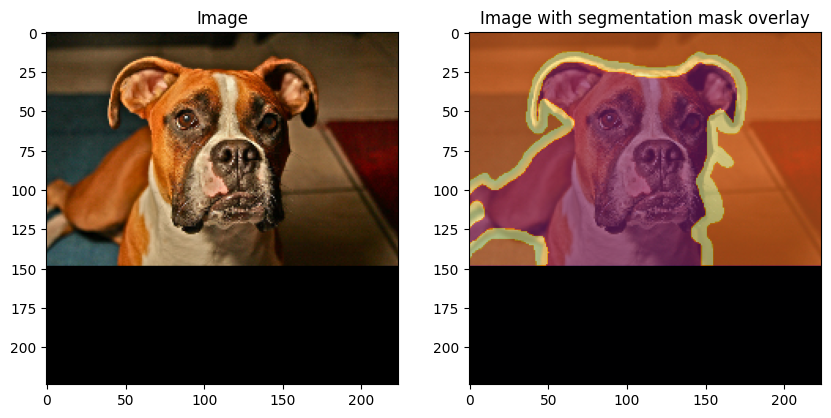

In [5]:
# Select random image and mask. Cast to NumPy array
# for Matplotlib visualization.

images, masks = next(iter(test_ds))
random_idx = tf.random.uniform([], minval=0, maxval=BATCH_SIZE, dtype=tf.int32)

test_image = images[random_idx].numpy().astype("float")
test_mask = masks[random_idx].numpy().astype("float")

# Overlay segmentation mask on top of image.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].set_title("Image")
ax[0].imshow(test_image / 255.0)

ax[1].set_title("Image with segmentation mask overlay")
ax[1].imshow(test_image / 255.0)
ax[1].imshow(
    test_mask,
    cmap="inferno",
    alpha=0.6,
)
plt.show()

## Perform VGG-specific pre-processing

`keras.applications.VGG19` requires the use of a `preprocess_input` function that will
pro-actively perform Image-net style Standard Deviation Normalization scheme.

In [6]:
def preprocess_data(image, segmentation_mask):
    image = keras.applications.vgg19.preprocess_input(image)
    return image, segmentation_mask


train_ds = (train_ds.map(preprocess_data, num_parallel_calls = AUTOTUNE)
            .shuffle(buffer_size = 1024)
            .prefetch(buffer_size = 1024))

val_ds = (val_ds.map(preprocess_data, num_parallel_calls = AUTOTUNE)
            .shuffle(buffer_size = 1024)
            .prefetch(buffer_size = 1024))

test_ds = (test_ds.map(preprocess_data, num_parallel_calls = AUTOTUNE)
            .shuffle(buffer_size = 1024)
            .prefetch(buffer_size = 1024))

## Model Definition

The Fully-Convolutional Network boasts a simple architecture composed of only
`keras.layers.Conv2D` Layers, `keras.layers.Dense` layers and `keras.layers.Dropout`
layers.

| ![FCN Architecture](https://i.imgur.com/PerTKjf.png) |
| :--: |
| **Diagram 2**: Generic FCN Forward Pass (Source: Paper)|

Pixel-wise prediction is performed by having a Softmax Convolutional layer with the same
size of the image, such that we can perform direct comparison
We can find several important metrics such as Accuracy and Mean-Intersection-over-Union on the network.



### Backbone (VGG-19)

We use the [VGG-19 network](https://keras.io/api/applications/vgg/) as the backbone, as
the paper suggests it to be one of the most effective backbones for this network.
We extract different outputs from the network by making use of `keras.models.Model`.
Following this, we add layers on top to make a network perfectly simulating that of
Diagram 1.
The backbone's `keras.layers.Dense` layers will be converted to `keras.layers.Conv2D`
layers based on the [original Caffe code present here.](https://github.com/linxi159/FCN-caffe/blob/master/pascalcontext-fcn16s/net.py)
All 3 networks will share the same backbone weights, but will have differing results
based on their extensions.
We make the backbone non-trainable to improve training time requirements.
It is also noted in the paper that making the network trainable does not yield major benefits.

In [7]:
input_layer = keras.Input(shape=(INPUT_HEIGHT, INPUT_WIDTH, 3))

# VGG Model backbone with pre-trained ImageNet weights.
vgg_model = keras.applications.vgg19.VGG19(include_top=True, weights="imagenet")

# Extracting different outputs from same model
fcn_backbone = keras.models.Model(
    inputs=vgg_model.layers[1].input,
    outputs=[
        vgg_model.get_layer(block_name).output
        for block_name in ["block3_pool", "block4_pool", "block5_pool"]
    ],
)

# Setting backbone to be non-trainable
fcn_backbone.trainable = False

x = fcn_backbone(input_layer)

# Converting Dense layers to Conv2D layers
units = [4096, 4096]
dense_convs = []

for filter_idx in range(len(units)):
    dense_conv = keras.layers.Conv2D(
        filters=units[filter_idx],
        kernel_size=(7, 7) if filter_idx == 0 else (1, 1),
        strides=(1, 1),
        activation="relu",
        padding="same",
        use_bias=False,
        kernel_initializer=tf.constant_initializer(1.0))
    dense_convs.append(dense_conv)
    dropout_layer = keras.layers.Dropout(0.5)
    dense_convs.append(dropout_layer)

dense_convs = keras.Sequential(dense_convs)
dense_convs.trainable = False

x[-1] = dense_convs(x[-1])

pool3_output, pool4_output, pool5_output = x

574710816/574710816 [==============================] - 6s 0us/step


### FCN-32S

We extend the last output, perform a `1x1 Convolution` and perform 2D Bilinear Upsampling
by a factor of 32 to get an image of the same size as that of our input.
We use a simple `keras.layers.UpSampling2D` layer over a `keras.layers.Conv2DTranspose`
since it yields performance benefits from being a deterministic mathematical operation
over a Convolutional operation
It is also noted in the paper that making the Up-sampling parameters trainable does not yield benefits.
Original experiments of the paper used Upsampling as well.

In [8]:
# 1x1 convolution to set channels = number of classes
pool5 = keras.layers.Conv2D(
    filters=NUM_CLASSES,
    kernel_size=(1, 1),
    padding="same",
    strides=(1, 1),
    activation="relu")

# Get Softmax outputs for all classes
fcn32s_conv_layer = keras.layers.Conv2D(
    filters=NUM_CLASSES,
    kernel_size=(1, 1),
    activation="softmax",
    padding="same",
    strides=(1, 1))

# Up-sample to original image size
fcn32s_upsampling = keras.layers.UpSampling2D(
    size=(32, 32),
    data_format=keras.backend.image_data_format(),
    interpolation="bilinear")

final_fcn32s_pool = pool5(pool5_output)
final_fcn32s_output = fcn32s_conv_layer(final_fcn32s_pool)
final_fcn32s_output = fcn32s_upsampling(final_fcn32s_output)

fcn32s_model = keras.Model(inputs=input_layer, outputs=final_fcn32s_output)

### FCN-16S

The pooling output from the FCN-32S is extended and added to the 4th-level Pooling output
of our backbone.
Following this, we upsample by a factor of 16 to get image of the same
size as that of our input.

In [9]:
# 1x1 convolution to set channels = number of classes
# Followed from the original Caffe implementation
pool4 = keras.layers.Conv2D(
    filters=NUM_CLASSES,
    kernel_size=(1, 1),
    padding="same",
    strides=(1, 1),
    activation="linear",
    kernel_initializer=keras.initializers.Zeros(),
)(pool4_output)

# Intermediate up-sample
pool5 = keras.layers.UpSampling2D(
    size=(2, 2),
    data_format=keras.backend.image_data_format(),
    interpolation="bilinear")(final_fcn32s_pool)

# Get Softmax outputs for all classes
fcn16s_conv_layer = keras.layers.Conv2D(
    filters=NUM_CLASSES,
    kernel_size=(1, 1),
    activation="softmax",
    padding="same",
    strides=(1, 1))

# Up-sample to original image size
fcn16s_upsample_layer = keras.layers.UpSampling2D(
    size=(16, 16),
    data_format=keras.backend.image_data_format(),
    interpolation="bilinear")

# Add intermediate outputs
final_fcn16s_pool = keras.layers.Add()([pool4, pool5])
final_fcn16s_output = fcn16s_conv_layer(final_fcn16s_pool)
final_fcn16s_output = fcn16s_upsample_layer(final_fcn16s_output)

fcn16s_model = keras.models.Model(inputs=input_layer, outputs=final_fcn16s_output)

### FCN-8S

The pooling output from the FCN-16S is extended once more, and added from the 3rd-level
Pooling output of our backbone.
This result is upsampled by a factor of 8 to get an image of the same size as that of our input.

In [10]:
# 1x1 convolution to set channels = number of classes
# Followed from the original Caffe implementation
pool3 = keras.layers.Conv2D(
    filters=NUM_CLASSES,
    kernel_size=(1, 1),
    padding="same",
    strides=(1, 1),
    activation="linear",
    kernel_initializer=keras.initializers.Zeros())(pool3_output)

# Intermediate up-sample
intermediate_pool_output = keras.layers.UpSampling2D(
    size=(2, 2),
    data_format=keras.backend.image_data_format(),
    interpolation="bilinear")(final_fcn16s_pool)

# Get Softmax outputs for all classes
fcn8s_conv_layer = keras.layers.Conv2D(
    filters=NUM_CLASSES,
    kernel_size=(1, 1),
    activation="softmax",
    padding="same",
    strides=(1, 1))

# Up-sample to original image size
fcn8s_upsample_layer = keras.layers.UpSampling2D(
    size=(8, 8),
    data_format=keras.backend.image_data_format(),
    interpolation="bilinear")

# Add intermediate outputs
final_fcn8s_pool = keras.layers.Add()([pool3, intermediate_pool_output])
final_fcn8s_output = fcn8s_conv_layer(final_fcn8s_pool)
final_fcn8s_output = fcn8s_upsample_layer(final_fcn8s_output)

fcn8s_model = keras.models.Model(inputs=input_layer, outputs=final_fcn8s_output)

In [11]:
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Load weights into backbone

It was noted in the paper, as well as through experimentation that extracting the weights
of the last 2 Fully-connected Dense layers from the backbone, reshaping the weights to
fit that of the `keras.layers.Dense` layers we had previously converted into
`keras.layers.Conv2D`, and setting them to it yields far better results and a significant
increase in mIOU performance.

In [12]:
# VGG's last 2 layers
weights1 = vgg_model.get_layer("fc1").get_weights()[0]
weights2 = vgg_model.get_layer("fc2").get_weights()[0]

weights1 = weights1.reshape(7, 7, 512, 4096)
weights2 = weights2.reshape(1, 1, 4096, 4096)

dense_convs.layers[0].set_weights([weights1])
dense_convs.layers[2].set_weights([weights2])

## Training

The original paper talks about making use of [SGD with Momentum](https://keras.io/api/optimizers/sgd/) as the optimizer of choice.
But it was noticed during experimentation that
[AdamW](https://keras.io/api/optimizers/adamw/)
yielded better results in terms of mIOU and Pixel-wise Accuracy.



### FCN-32S

In [14]:
fcn32s_optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

fcn32s_loss = keras.losses.SparseCategoricalCrossentropy()

# Maintain mIOU and Pixel-wise Accuracy as metrics
fcn32s_model.compile(
    optimizer=fcn32s_optimizer,
    loss=fcn32s_loss,
    metrics=[
        keras.metrics.MeanIoU(num_classes=NUM_CLASSES, sparse_y_pred=False),
        keras.metrics.SparseCategoricalAccuracy(),
    ])

fcn32s_history = fcn32s_model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/20
98/98 [==============================] - 79s 270ms/step - loss: 0.9982 - mean_io_u_1: 0.2982 - sparse_categorical_accuracy: 0.6236 - val_loss: 0.8274 - val_mean_io_u_1: 0.3836 - val_sparse_categorical_accuracy: 0.6792
Epoch 2/20
98/98 [==============================] - 51s 194ms/step - loss: 0.7538 - mean_io_u_1: 0.3924 - sparse_categorical_accuracy: 0.7056 - val_loss: 0.7181 - val_mean_io_u_1: 0.4194 - val_sparse_categorical_accuracy: 0.7190
Epoch 3/20
98/98 [==============================] - 50s 195ms/step - loss: 0.7051 - mean_io_u_1: 0.4116 - sparse_categorical_accuracy: 0.7209 - val_loss: 0.6755 - val_mean_io_u_1: 0.4372 - val_sparse_categorical_accuracy: 0.7353
Epoch 4/20
98/98 [==============================] - 48s 180ms/step - loss: 0.6709 - mean_io_u_1: 0.4205 - sparse_categorical_accuracy: 0.7329 - val_loss: 0.6725 - val_mean_io_u_1: 0.4319 - val_sparse_categorical_accuracy: 0.7319
Epoch 5/20
98/98 [==============================] - 49s 182ms/step - loss: 0.6596 - 

### FCN-16S

In [16]:
fcn16s_optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

fcn16s_loss = keras.losses.SparseCategoricalCrossentropy()

# Maintain mIOU and Pixel-wise Accuracy as metrics
fcn16s_model.compile(
    optimizer=fcn16s_optimizer,
    loss=fcn16s_loss,
    metrics=[
        keras.metrics.MeanIoU(num_classes=NUM_CLASSES, sparse_y_pred=False),
        keras.metrics.SparseCategoricalAccuracy(),
    ],
)

fcn16s_history = fcn16s_model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/20
98/98 [==============================] - 66s 226ms/step - loss: 5.8494 - mean_io_u_3: 0.3689 - sparse_categorical_accuracy: 0.5839 - val_loss: 5.8928 - val_mean_io_u_3: 0.3923 - val_sparse_categorical_accuracy: 0.5939
Epoch 2/20
98/98 [==============================] - 52s 191ms/step - loss: 5.2731 - mean_io_u_3: 0.3981 - sparse_categorical_accuracy: 0.6347 - val_loss: 5.8776 - val_mean_io_u_3: 0.3893 - val_sparse_categorical_accuracy: 0.5941
Epoch 3/20
98/98 [==============================] - 53s 194ms/step - loss: 5.2111 - mean_io_u_3: 0.3951 - sparse_categorical_accuracy: 0.6387 - val_loss: 5.8722 - val_mean_io_u_3: 0.3848 - val_sparse_categorical_accuracy: 0.5950
Epoch 4/20
98/98 [==============================] - 49s 185ms/step - loss: 5.2177 - mean_io_u_3: 0.3928 - sparse_categorical_accuracy: 0.6375 - val_loss: 5.8670 - val_mean_io_u_3: 0.3871 - val_sparse_categorical_accuracy: 0.5939
Epoch 5/20
98/98 [==============================] - 52s 197ms/step - loss: 5.2443 - 

### FCN-8S

In [18]:
fcn8s_optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

fcn8s_loss = keras.losses.SparseCategoricalCrossentropy()

# Maintain mIOU and Pixel-wise Accuracy as metrics
fcn8s_model.compile(
    optimizer=fcn8s_optimizer,
    loss=fcn8s_loss,
    metrics=[
        keras.metrics.MeanIoU(num_classes=NUM_CLASSES, sparse_y_pred=False),
        keras.metrics.SparseCategoricalAccuracy(),
    ],
)

fcn8s_history = fcn8s_model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/20
98/98 [==============================] - 52s 188ms/step - loss: 8.9559 - mean_io_u_5: 0.2515 - sparse_categorical_accuracy: 0.4146 - val_loss: 7.8751 - val_mean_io_u_5: 0.2780 - val_sparse_categorical_accuracy: 0.4839
Epoch 2/20
98/98 [==============================] - 53s 224ms/step - loss: 8.7592 - mean_io_u_5: 0.2671 - sparse_categorical_accuracy: 0.4312 - val_loss: 7.8514 - val_mean_io_u_5: 0.2810 - val_sparse_categorical_accuracy: 0.4820
Epoch 3/20
98/98 [==============================] - 49s 182ms/step - loss: 8.6907 - mean_io_u_5: 0.2594 - sparse_categorical_accuracy: 0.4311 - val_loss: 7.8503 - val_mean_io_u_5: 0.2601 - val_sparse_categorical_accuracy: 0.4742
Epoch 4/20
98/98 [==============================] - 50s 199ms/step - loss: 8.7316 - mean_io_u_5: 0.2586 - sparse_categorical_accuracy: 0.4262 - val_loss: 7.8050 - val_mean_io_u_5: 0.2743 - val_sparse_categorical_accuracy: 0.4812
Epoch 5/20
98/98 [==============================] - 53s 225ms/step - loss: 8.7220 - 

## Visualizations



### Plotting metrics for training run

We perform a comparative study between all 3 versions of the model by tracking training
and validation metrics of Accuracy, Loss and Mean IoU.

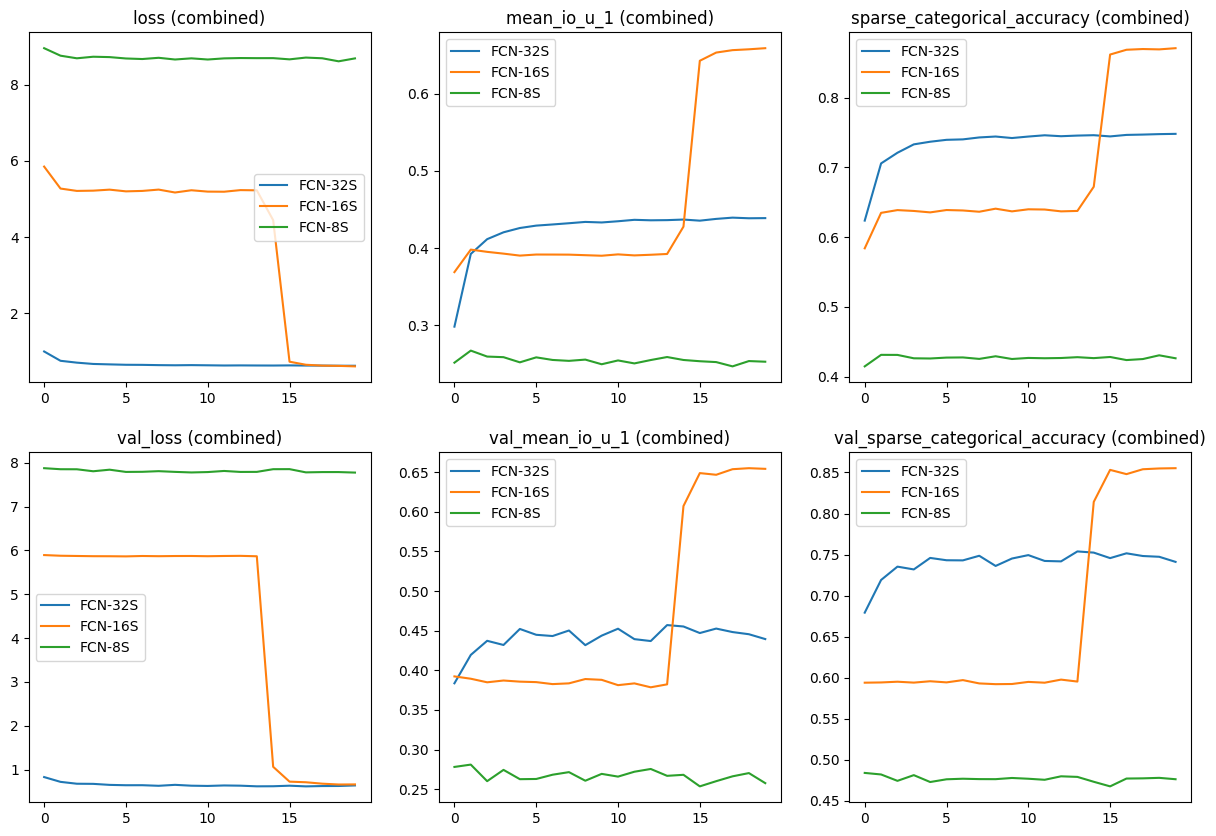

In [19]:
total_plots = len(fcn32s_history.history)
cols = total_plots // 2

rows = total_plots // cols

if total_plots % cols != 0:
    rows += 1

# Set all history dictionary objects
fcn32s_dict = fcn32s_history.history
fcn16s_dict = fcn16s_history.history
fcn8s_dict = fcn8s_history.history

pos = range(1, total_plots + 1)
plt.figure(figsize=(15, 10))

for i, ((key_32s, value_32s), (key_16s, value_16s), (key_8s, value_8s)) in enumerate(
    zip(fcn32s_dict.items(), fcn16s_dict.items(), fcn8s_dict.items())
):
    plt.subplot(rows, cols, pos[i])
    plt.plot(range(len(value_32s)), value_32s)
    plt.plot(range(len(value_16s)), value_16s)
    plt.plot(range(len(value_8s)), value_8s)
    plt.title(str(key_32s) + " (combined)")
    plt.legend(["FCN-32S", "FCN-16S", "FCN-8S"])

plt.show()

### Visualizing predicted segmentation masks

To understand the results and see them better, we pick a random image from the test
dataset and perform inference on it to see the masks generated by each model.
Note: For better results, the model must be trained for a higher number of epochs.

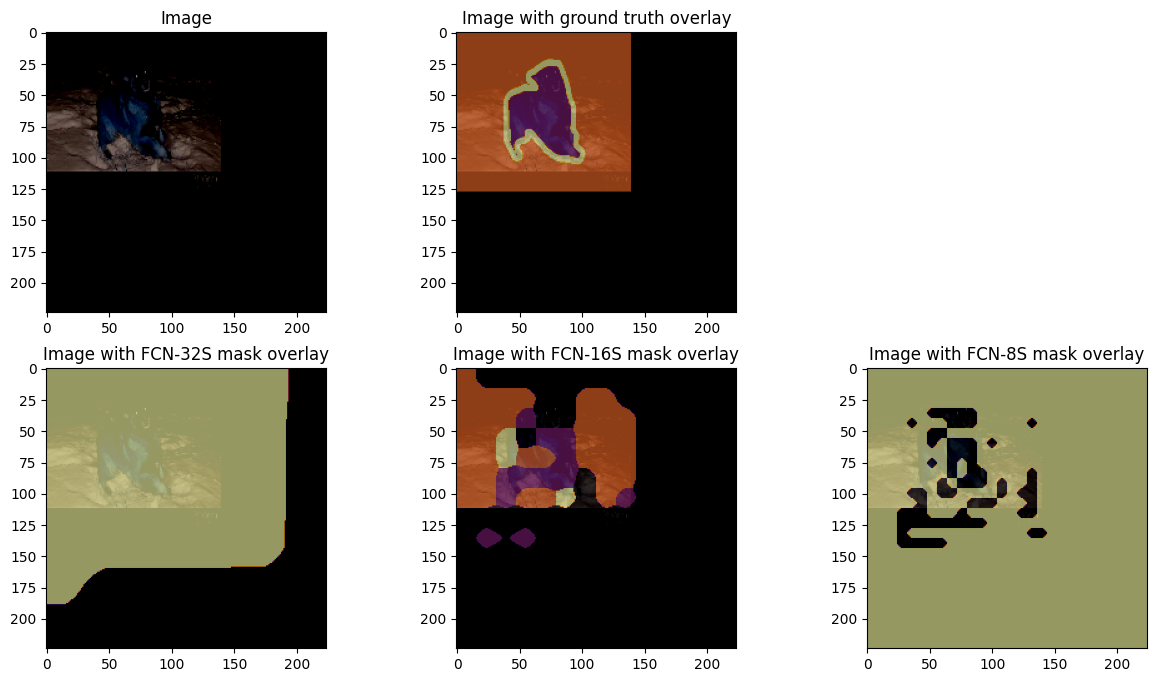

In [20]:
images, masks = next(iter(test_ds))
random_idx = tf.random.uniform([], minval=0, maxval=BATCH_SIZE, dtype=tf.int32)

# Get random test image and mask
test_image = images[random_idx].numpy().astype("float")
test_mask = masks[random_idx].numpy().astype("float")

pred_image = tf.expand_dims(test_image, axis=0)
pred_image = keras.applications.vgg19.preprocess_input(pred_image)

# Perform inference on FCN-32S
pred_mask_32s = fcn32s_model.predict(pred_image, verbose=0).astype("float")
pred_mask_32s = np.argmax(pred_mask_32s, axis=-1)
pred_mask_32s = pred_mask_32s[0, ...]

# Perform inference on FCN-16S
pred_mask_16s = fcn16s_model.predict(pred_image, verbose=0).astype("float")
pred_mask_16s = np.argmax(pred_mask_16s, axis=-1)
pred_mask_16s = pred_mask_16s[0, ...]

# Perform inference on FCN-8S
pred_mask_8s = fcn8s_model.predict(pred_image, verbose=0).astype("float")
pred_mask_8s = np.argmax(pred_mask_8s, axis=-1)
pred_mask_8s = pred_mask_8s[0, ...]

# Plot all results
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

fig.delaxes(ax[0, 2])

ax[0, 0].set_title("Image")
ax[0, 0].imshow(test_image / 255.0)

ax[0, 1].set_title("Image with ground truth overlay")
ax[0, 1].imshow(test_image / 255.0)
ax[0, 1].imshow(
    test_mask,
    cmap="inferno",
    alpha=0.6,
)

ax[1, 0].set_title("Image with FCN-32S mask overlay")
ax[1, 0].imshow(test_image / 255.0)
ax[1, 0].imshow(pred_mask_32s, cmap="inferno", alpha=0.6)

ax[1, 1].set_title("Image with FCN-16S mask overlay")
ax[1, 1].imshow(test_image / 255.0)
ax[1, 1].imshow(pred_mask_16s, cmap="inferno", alpha=0.6)

ax[1, 2].set_title("Image with FCN-8S mask overlay")
ax[1, 2].imshow(test_image / 255.0)
ax[1, 2].imshow(pred_mask_8s, cmap="inferno", alpha=0.6)

plt.show()

## Conclusion

The Fully-Convolutional Network is an exceptionally simple network that has yielded
strong results in Image Segmentation tasks across different benchmarks.
With the advent of better mechanisms like [Attention](https://arxiv.org/abs/1706.03762) as used in
[SegFormer](https://arxiv.org/abs/2105.15203) and
[DeTR](https://arxiv.org/abs/2005.12872), this model serves as a quick way to iterate and
find baselines for this task on unknown data.